# Federated learning with PySyft

In this notebook we will learn how to run a Federated Learning experiment, using **Scikit-learn** and **PySyft**.

## Step 1. Login to datasites as **External Researcher**

Launch Datasites if not running:
```bash
$ python launch_datasites.py
```

In [1]:
import syft as sy

In [2]:
from datasites import DATASITE_URLS

datasites = {}
for name, url in DATASITE_URLS.items():
    datasites[name] = sy.login(url=url, email="researcher@openmined.org", password="****")

Logged into <Cleveland Clinic: High side Datasite> as <researcher@openmined.org>
Logged into <Hungarian Inst. of Cardiology: High side Datasite> as <researcher@openmined.org>
Logged into <Univ. Hospitals Zurich and Basel: High side Datasite> as <researcher@openmined.org>
Logged into <V.A. Medical Center: High side Datasite> as <researcher@openmined.org>


## Step 2. Get Mock data and test the code for the Machine Learning (`ML`) experiment

In [3]:
mock_data = datasites["Cleveland Clinic"].datasets["Heart Disease Dataset"].assets["Heart Study Data"].mock

**TYPE ANNOTATIONS**

Let's use some type annotations to better document the input/output of each step in the `ML` experiment.

In [4]:
import numpy as np
import numpy.typing as npt
from typing import Union, TypeVar, Any

DataFrame = TypeVar("pandas.DataFrame")
NDArray = npt.NDArray[Any]
NDArrayInt = npt.NDArray[np.int_]
NDArrayFloat = npt.NDArray[np.float_]

Dataset = TypeVar("Dataset", bound=tuple[NDArrayFloat, NDArrayInt])
Metric = TypeVar("Metric", bound=dict[str, Union[float, NDArrayInt]])
Metrics = TypeVar("Metrics", bound=tuple[Metric, Metric])  # train and test
ModelParams = TypeVar("ModelParams", bound=dict[str, NDArrayFloat])
Result = TypeVar("Result", bound=tuple[Metrics, ModelParams])

In [5]:
def ml_experiment(data: DataFrame, model_params: ModelParams = None) -> Result:
    """ML Experiment using a PassiveAggressive (linear) Classifier.
    Steps:
    1. Preprocessing (partitioning; missing values & scaling)
    2. Model setup (w/ `model_params`)
    3. Training: gather updated model parameters
    4. Evaluation: collect metrics on training and test partitions

    Parameters
    ----------
    data : DataFrame
        Input Heart Study data represented as Pandas DataFrame.
    model_params: ModelParams (dict)
        DL Model Parameters

    Returns
    -------
    metrics : Metrics
        Evaluation metrics (i.e. MCC, Confusion matrix) on both training and test
        data partitions.
    model_params : ModelParams
        Update model params after training.
    """
    # preprocessing
    from sklearn.model_selection import train_test_split
    from sklearn.compose import ColumnTransformer
    from sklearn.pipeline import Pipeline
    from sklearn.impute import SimpleImputer
    from sklearn.preprocessing import RobustScaler

    # training (model)
    from sklearn.linear_model import PassiveAggressiveClassifier

    # evaluation (metrics)
    from sklearn.metrics import matthews_corrcoef as mcc
    from sklearn.metrics import confusion_matrix
        
    def preprocess(data: DataFrame) -> tuple[Dataset, Dataset]:

        def by_demographics(data: DataFrame) -> NDArray:
            sex = data["sex"].map(lambda v: "0" if v == 0 else "1")
            target = data["num"].map(lambda v: "0" if v == 0 else "1")
            return (sex + target).values

        X = data.drop(columns=["age", "sex", "num"], axis=1)
        y = data["num"].map(lambda v: 0 if v == 0 else 1)

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, random_state=12345, stratify=by_demographics(data))
        
        preprocessor = ColumnTransformer(
            transformers=[("numerical",
                           Pipeline(steps=[("imputer", SimpleImputer(strategy="mean")),
                                           ("scaler", RobustScaler()),]),
                           ["trestbps", "chol", "thalach", "oldpeak"]),
                          ("categorical", 
                           SimpleImputer(strategy="most_frequent",),
                           ["ca", "cp", "exang", "fbs", "restecg", "slope", "thal"])])
        X_train = preprocessor.fit_transform(X_train)
        X_test = preprocessor.transform(X_test)
        return (X_train, y_train), (X_test, y_test)

    def train(model, training_data: Dataset) -> ModelParams:
        X_train, y_train = training_data
        model.fit(X_train, y_train)
        return {"intercept": model.intercept_, "coefs": model.coef_}

    def evaluate(model, data: Dataset) -> Metric:
        X, y_true = data
        y_pred = model.predict(X)
        return {"mcc": mcc(y_true, y_pred), "cm": confusion_matrix(y_true, y_pred)}

    # -- ML Experiment --
    # 1. preprocessing
    training_data, test_data = preprocess(data)
    # 2. model setup
    clf = PassiveAggressiveClassifier(random_state=12345, warm_start=True)
    if model_params:
        clf.classes_ = [0, 1]
        clf.intercept_ = model_params["intercept"]
        clf.coef_ = model_params["coefs"]
    # 3. training
    model_params = train(clf, training_data)
    # 4. evaluation
    training_metrics = evaluate(clf, training_data)
    test_metrics = evaluate(clf, test_data)
    return (training_metrics, test_metrics), model_params


In [6]:
metrics, model_params = ml_experiment(data=mock_data)

In [7]:
metrics

({'mcc': 0.24725644494198337,
  'cm': array([[24,  7],
         [61, 72]])},
 {'mcc': 0.04506150586965626,
  'cm': array([[ 7,  3],
         [29, 16]])})

In [8]:
model_params

{'intercept': array([1.18247726]),
 'coefs': array([[ 0.32665928,  0.08919194, -0.20667732, -0.13076033, -0.02091345,
          0.17903009, -0.27179835,  0.00315412, -0.19264865,  0.10122958,
         -0.29319796]])}

## Step 3. FL Experiment

In [9]:
from syft.service.policy.policy import MixedInputPolicy

In [10]:
for name, datasite in datasites.items():
    data_asset = datasite.datasets["Heart Disease Dataset"].assets["Heart Study Data"]
    syft_fl_experiment = sy.syft_function(
        input_policy=MixedInputPolicy(
            client=datasite, data=data_asset, model_params=dict
        )
    )(ml_experiment)
    ml_training_project = sy.Project(
        name="ML Experiment for FL",
        description="""I would like to run this ML experiment on Heart Disease data, to be used in a Federated Learning fashion. 
        The function will iteratively receive an input dictionary containing the average model parameters 
        resulting from the FL experiment iteration on all the four Hospitals datasites.
        Training and Test metrics will be returned after each run to monitor the learning progress.""",
        members=[datasite],
    )
    ml_training_project.create_code_request(syft_fl_experiment, datasite)
    project = ml_training_project.send()

SyftSuccess: Syft function 'ml_experiment' successfully created. To add a code request, please create a project using `project = syft.Project(...)`, then use command `project.create_code_request`.

SyftSuccess: Syft function 'ml_experiment' successfully created. To add a code request, please create a project using `project = syft.Project(...)`, then use command `project.create_code_request`.

SyftSuccess: Syft function 'ml_experiment' successfully created. To add a code request, please create a project using `project = syft.Project(...)`, then use command `project.create_code_request`.

SyftSuccess: Syft function 'ml_experiment' successfully created. To add a code request, please create a project using `project = syft.Project(...)`, then use command `project.create_code_request`.

In [11]:
from utils import check_status_last_code_requests

check_status_last_code_requests(datasites)

Datasite: Cleveland Clinic


"<class 'syft.service.code.user_code.UserCodeStatusCollection'> approved"

Datasite: Hungarian Inst. of Cardiology


"<class 'syft.service.code.user_code.UserCodeStatusCollection'> approved"

Datasite: Univ. Hospitals Zurich and Basel


"<class 'syft.service.code.user_code.UserCodeStatusCollection'> approved"

Datasite: V.A. Medical Center


"<class 'syft.service.code.user_code.UserCodeStatusCollection'> approved"

In [12]:
import numpy as np
from collections import defaultdict

In [13]:
def avg(all_models_params: list[ModelParams]) -> ModelParams: 
    return {"intercept": np.average([p["intercept"] for p in all_models_params], axis=0), 
            "coefs": np.average([p["coefs"] for p in all_models_params], axis=0)}

def fl_experiment(datasites: dict[str, sy.DatasiteClient], fl_epochs: int = 15):
    fl_model_params, fl_metrics = dict(), defaultdict(list)  # one entry per epoch as a list
    for epoch in range(fl_epochs):
        for datasite in datasites.values():
            data_asset = datasite.datasets["Heart Disease Dataset"].assets["Heart Study Data"]
            metrics, params = datasite.code.ml_experiment(data=data_asset, model_params=fl_model_params).get_from(datasite)
            fl_metrics[epoch].append((metrics, params))
        fl_model_params = avg([params for _, params in fl_metrics[epoch]])
    return fl_metrics

In [14]:
fl_metrics = fl_experiment(datasites, fl_epochs=15)

## Step 4. Plot Results

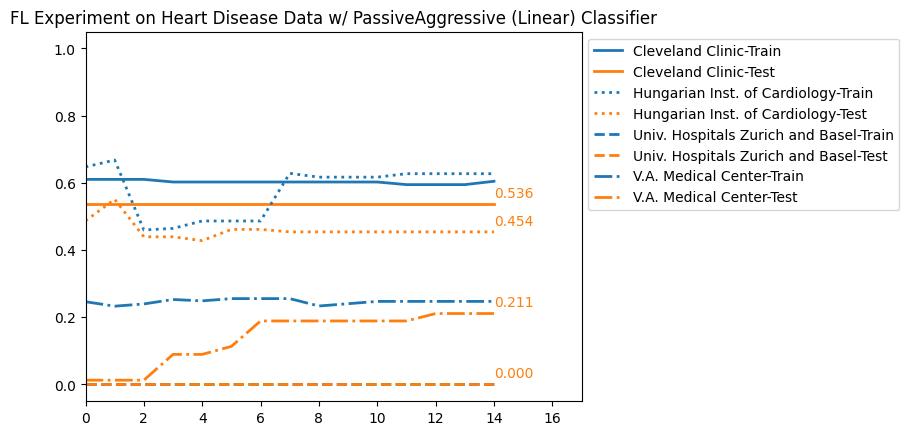

In [15]:
from matplotlib import pyplot as plt
from utils import plot_fl_metrics

plot_fl_metrics(datasites, fl_metrics, title="FL Experiment on Heart Disease Data w/ PassiveAggressive (Linear) Classifier")
plt.show()

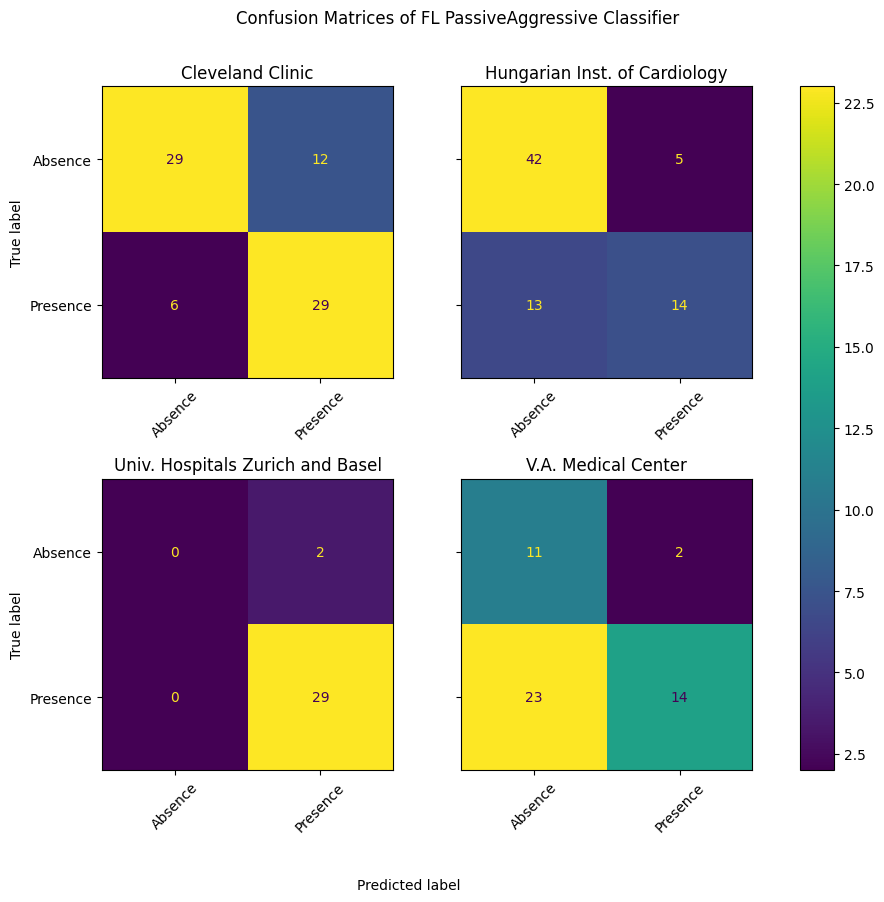

In [16]:
from utils import plot_all_confusion_matrices

last_epoch = sorted(fl_metrics)[-1]
confusion_matrices = {name: fl_metrics[last_epoch][idx][0][1]["cm"] for idx, name in enumerate(datasites)}
plot_all_confusion_matrices(confusion_matrices, title="Confusion Matrices of FL PassiveAggressive Classifier")
plt.show()

## Conclusions

_complete_